In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from src.structs import Indicator, Country
from src.utils import (
    plot_time_series,
    PlotOptions,
    pacf_plot,
    acf_plot,
    Matrix,
    Float,
    normalize,
)
from src.data import serialize_country_data
from src.statistics import (
    correlation,
    differencing,
    stationarity,
    autocorrelation,
    residuals_autocorrelation,
)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from typing import Any, Literal
from statsmodels.regression.linear_model import RegressionResultsWrapper, OLS
from scipy.stats import spearmanr, kendalltau
from statsmodels.stats.stattools import durbin_watson



In [3]:
def plot_country(
    features: dict[Indicator, Matrix[Literal["N"], Float]],
    years: Matrix[Literal["N"], np.str_],
    country: Country,
):
    for indicator in Indicator:
        ts = features[indicator]

        plot_time_series(
            years,
            ts,
            13,
            PlotOptions(
                "",
                f"{country.name} {indicator.name}",
                "Date",
                "val",
                [f"{indicator.name}", f"{indicator.name} Average"],
                False,
            ),
        )

        pacf_plot(
            years,
            ts,
            len(years) // 2,
            PlotOptions(
                "",
                f"PACF of {indicator.name}",
                "Lag",
                "val",
                [f"PACF of {indicator.name}"],
                False,
            ),
        )

        acf_plot(
            years,
            ts,
            len(years) // 2,
            PlotOptions(
                "",
                f"ACF of {indicator.name}",
                "Lag",
                "val",
                [f"ACF of {indicator.name}"],
                False,
            ),
        )

In [4]:
def prais_winsten(
    model: RegressionResultsWrapper, rho: float
) -> RegressionResultsWrapper:
    x = model.model.exog
    y = model.model.endog

    # prais winsten transformation for first element
    x_0: Matrix[Literal["1"], Float] = np.sqrt(1 - rho**2) * x[0]
    y_0: Matrix[Literal["1"], Float] = np.sqrt(1 - rho**2) * y[0]

    # cochran orcutt transformation for the rest of the elements
    x_t: Matrix[Literal["N - 1"], Float] = x[1:,] - rho * x[:-1,]
    x_t: Matrix[Literal["N "], Float] = np.append([x_0], x_t, axis=0)
    y_t: Matrix[Literal["N - 1"], Float] = y[1:] - rho * y[:-1]
    y_t: Matrix[Literal["N"], Float] = np.append(y_0, y_t)

    model_ar1 = OLS(y_t, x_t).fit()
    return model_ar1


def prais_winsten_estimation(
    x: Matrix[Literal["N M"], Float], y: Matrix[Literal["N"], Float]
) -> RegressionResultsWrapper:
    model = OLS(y, x).fit()
    e_0: Matrix[Literal["N - 1"], Float] = model.resid[1:]
    e_1: Matrix[Literal["N - 1"], Float] = model.resid[:-1]
    rho = np.dot(e_1, e_0) / np.dot(e_1, e_1)
    rho = rho.item()
    model1 = prais_winsten(model, rho)

    dw = durbin_watson(model1.resid)
    tolerance = 1e-3
    while dw < 2 - tolerance or dw > 2 + tolerance:
        model1 = prais_winsten(model1, rho)
        e_0 = model1.resid[1:]
        e_1 = model1.resid[:-1]
        rho = np.dot(e_1, e_0) / np.dot(e_1, e_1)
        rho = rho.item()
        dw = durbin_watson(model1.resid)
        print("Rho = ", rho)

    return model1

In [5]:
def bootstrap_correlation(
    ts1: Matrix[Literal["N"], Float],
    ts2: Matrix[Literal["N"], Float],
    repetitions: int,
    alpha: float,
) -> list[dict[str, Any]]:
    pearson_correlations: list[float] = []
    kendall_correlations: list[float] = []
    spearman_correlations: list[float] = []

    num_samples = ts1.shape[0]
    for _ in range(repetitions):
        indices = np.random.choice(num_samples, num_samples, replace=True)
        sample1 = ts1[indices]
        sample2 = ts2[indices]
        pearson_correlations.append(np.corrcoef(sample1, sample2)[0, 1])
        kendall_correlations.append(kendalltau(sample1, sample2).statistic) # type: ignore
        spearman_correlations.append(spearmanr(sample1, sample2).statistic) # type: ignore

    pearson = {
        "mean": np.mean(pearson_correlations),
        "std": np.std(pearson_correlations),
        "confidence_interval": [
            np.percentile(pearson_correlations, 100 * alpha / 2),
                        np.percentile(pearson_correlations, 100 * (1 - alpha / 2)),
        ],
    }

    kendall = {
        "mean": np.mean(kendall_correlations),
        "std": np.std(kendall_correlations),
        "confidence_interval": [
            np.percentile(kendall_correlations, 100 * alpha / 2),
            np.percentile(kendall_correlations, 100 * (1 - alpha / 2)),
        ],
    }

    spearman = {
        "mean": np.mean(spearman_correlations),
        "std": np.std(spearman_correlations),
        "confidence_interval": [
            np.percentile(spearman_correlations, 100 * alpha / 2),
            np.percentile(spearman_correlations, 100 * (1 - alpha / 2)),
        ],
    }

    return [pearson, kendall, spearman]

In [6]:
df = pd.read_csv("../data/cleaned/dataset.csv")
country = Country.SOUTH_AFRICA
features, years = serialize_country_data(df, country, pct=False)
features[Indicator.GDP] = features[Indicator.GDP] / 1e9

In [7]:
normalized_data: Matrix[Literal["N 3"], Float] = np.stack(
    [features[indicator] for indicator in Indicator]
)
normalized_features = {
    Indicator.GDP: normalized_data[0],
    Indicator.IR: normalized_data[1],
    Indicator.CPI: normalized_data[2],
}

In [8]:
# normalized_data: Matrix[Literal["N 3"], Float] = np.stack(
#     [features[indicator] for indicator in Indicator]
# )
# normalized_data = normalize(normalized_data)
# normalized_features = {
#     Indicator.GDP: normalized_data[0],
#     Indicator.IR: normalized_data[1],
#     Indicator.CPI: normalized_data[2],
# }

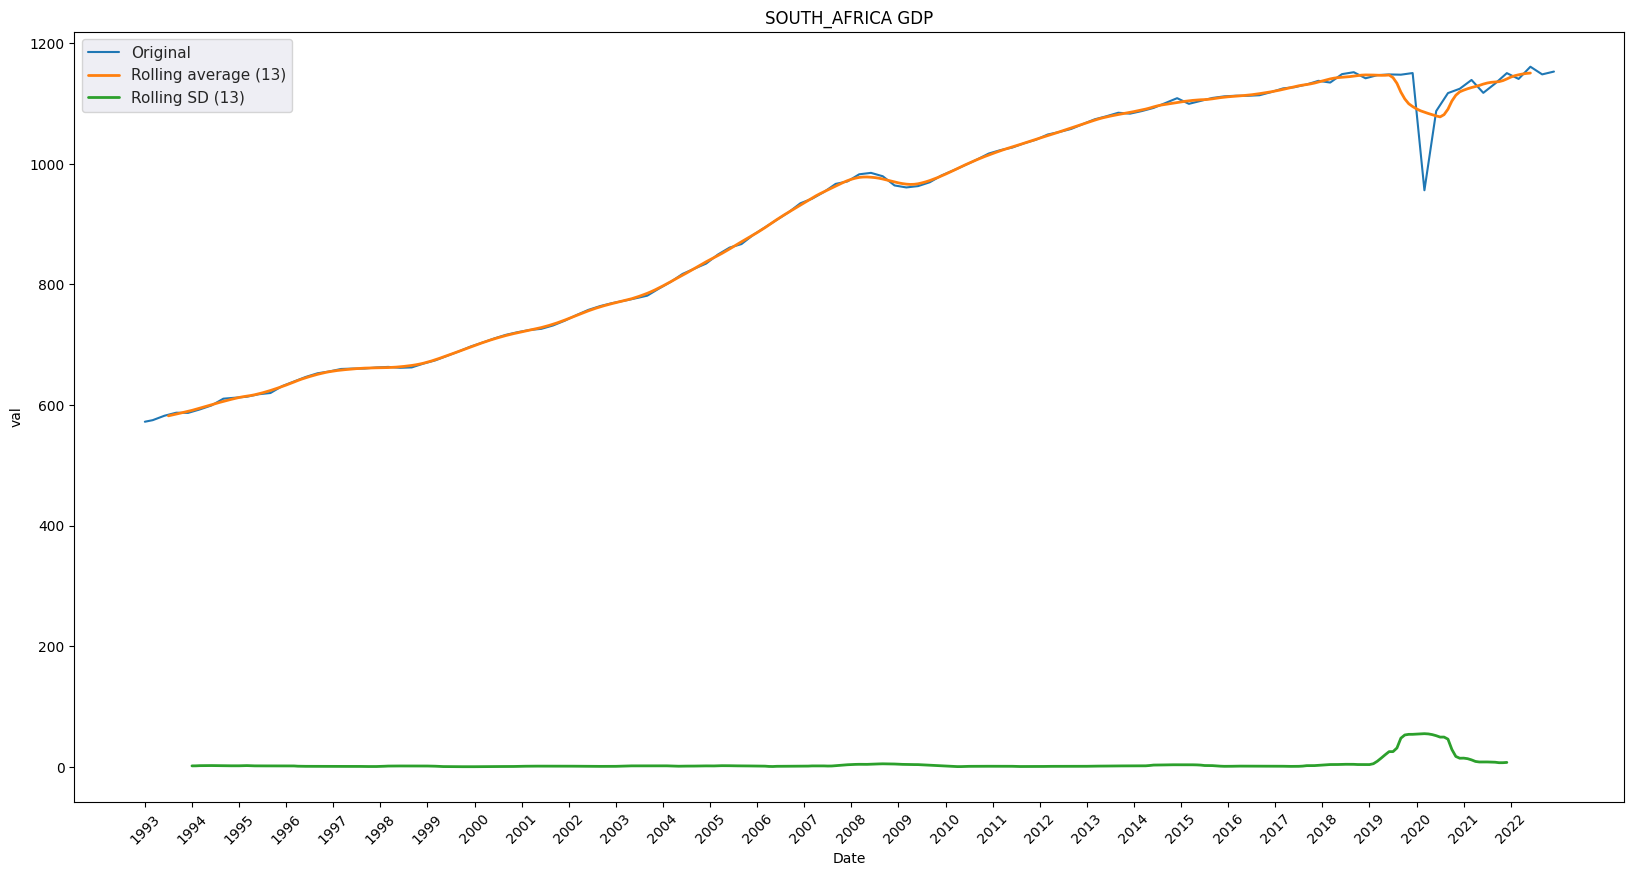

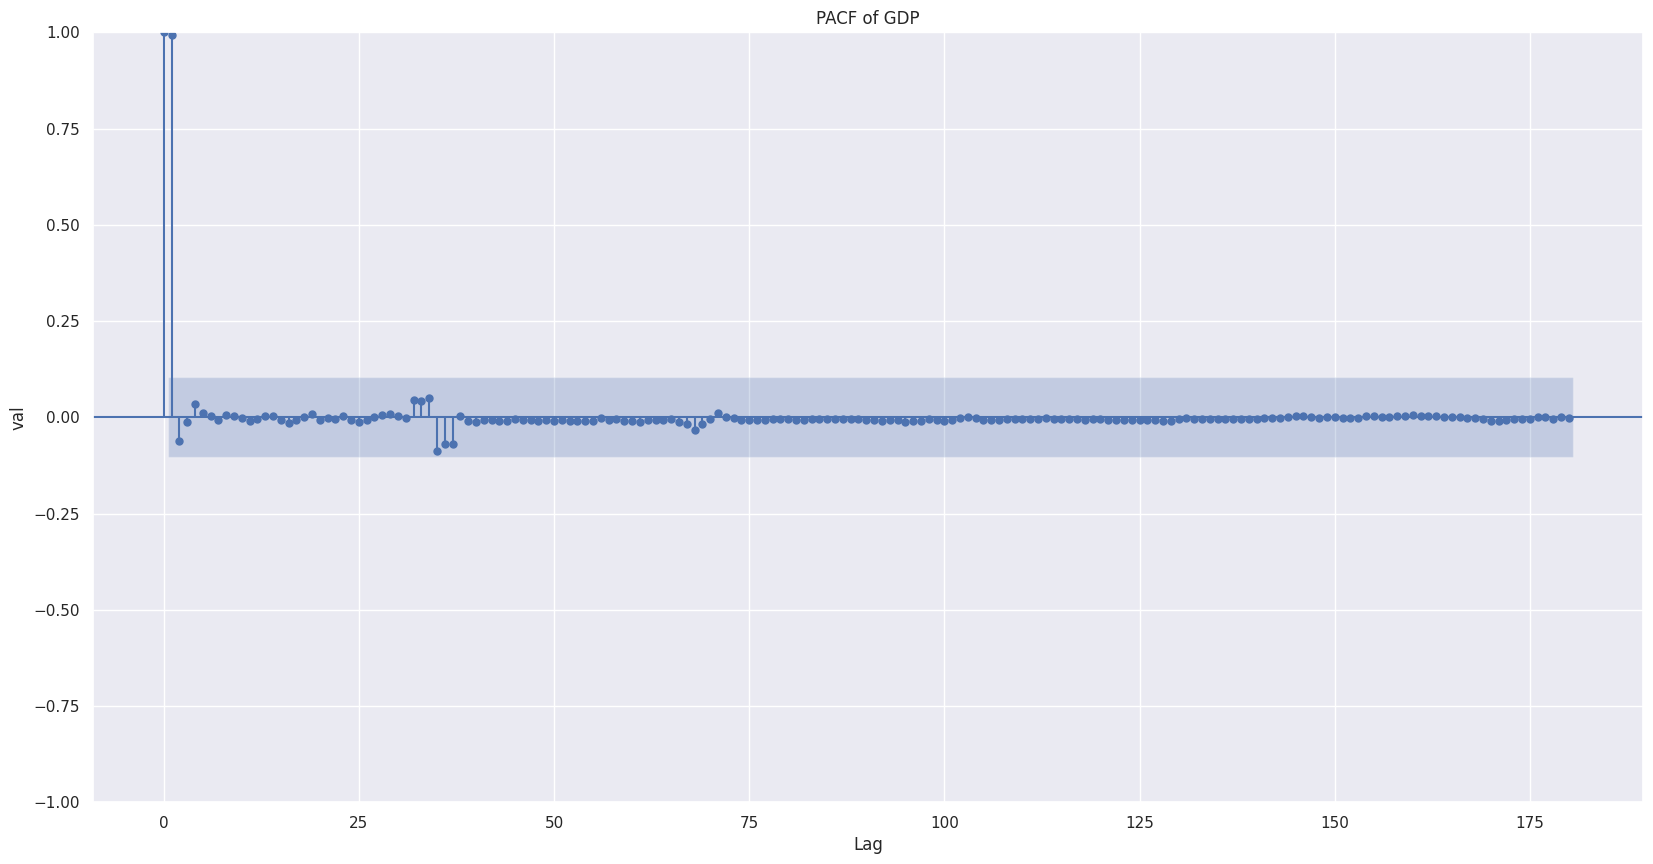

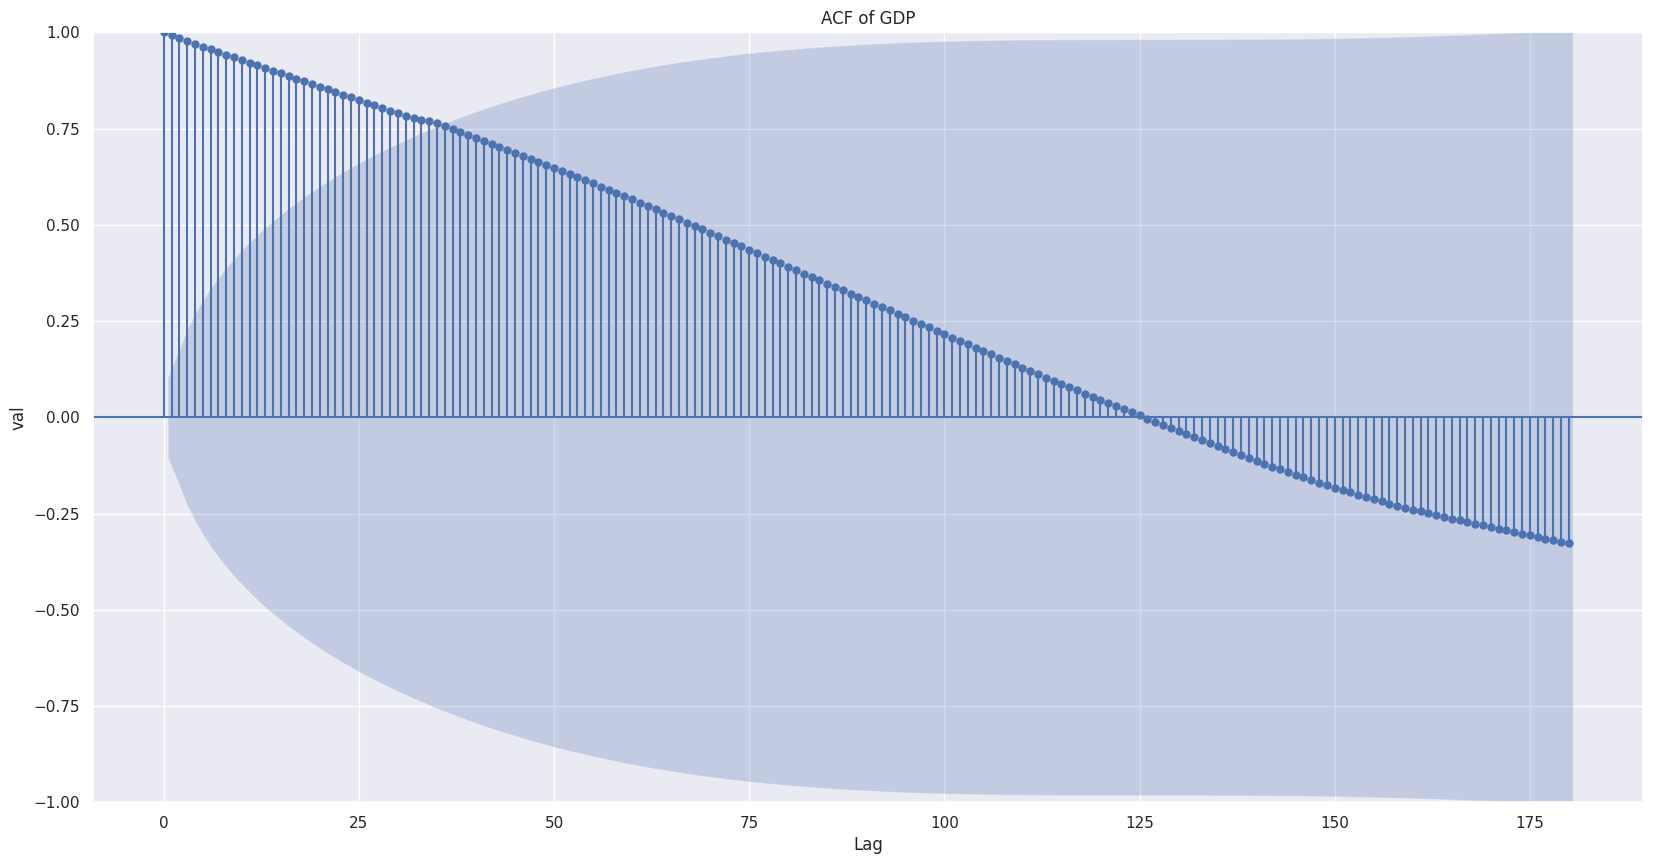

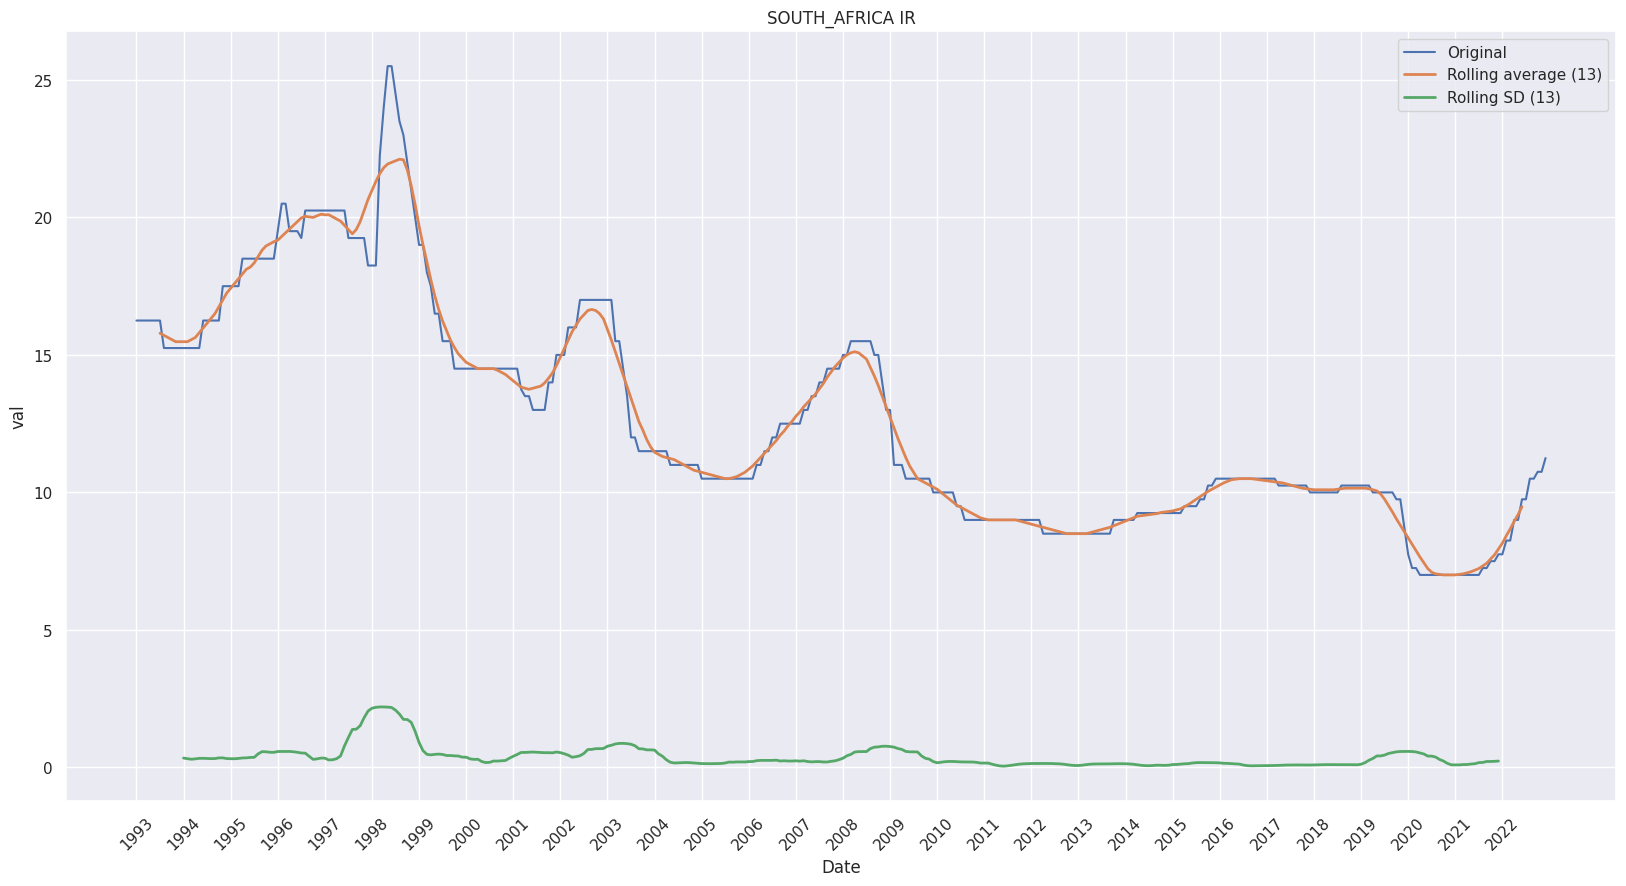

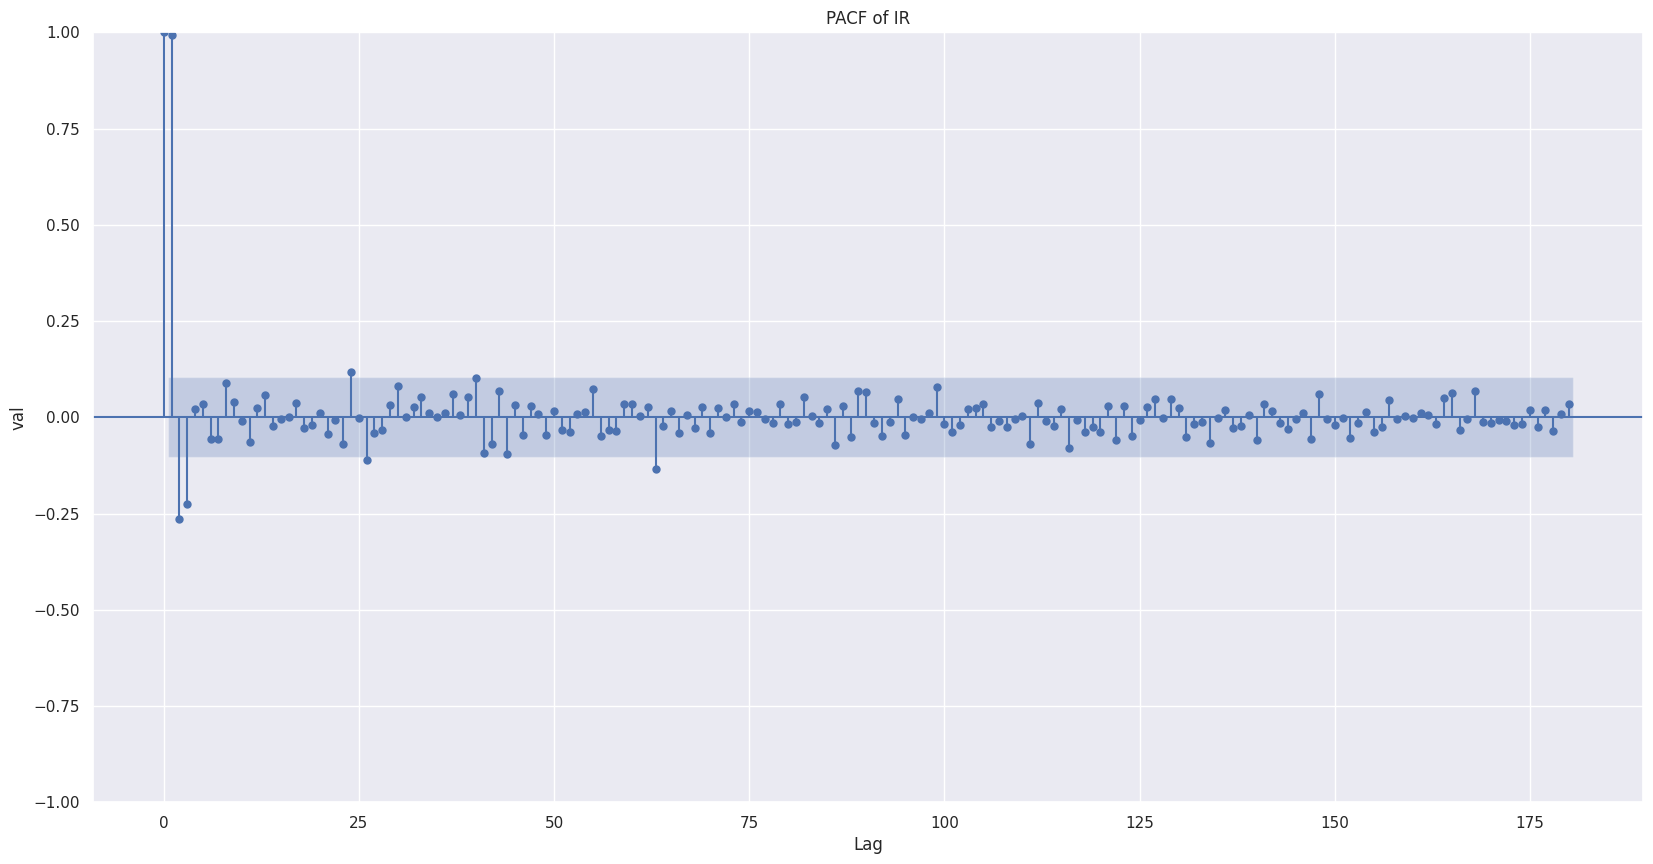

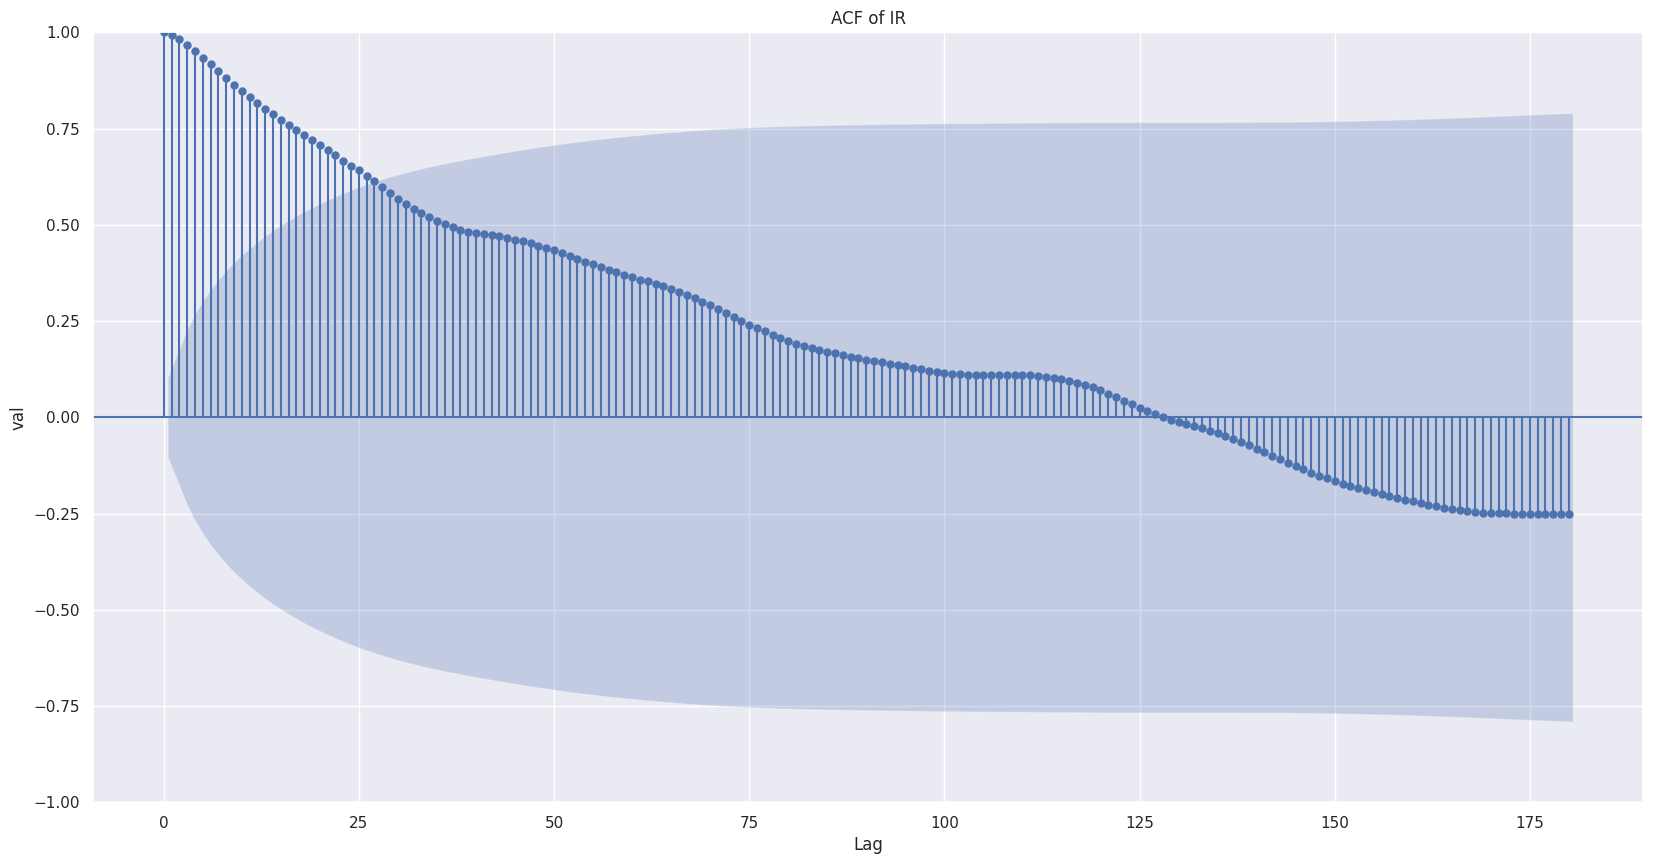

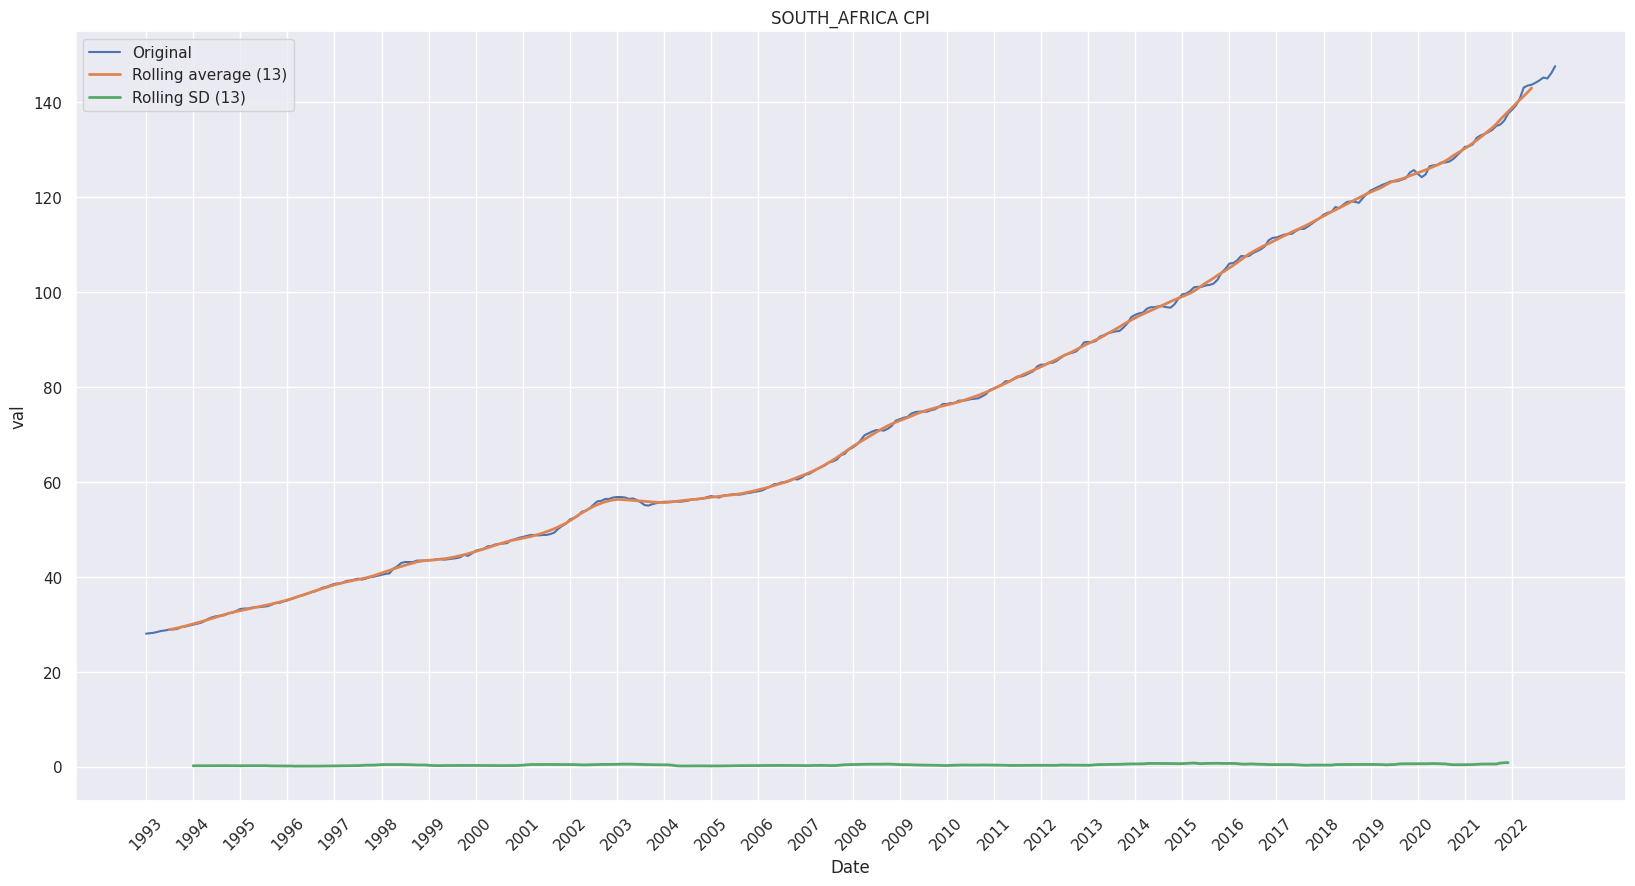

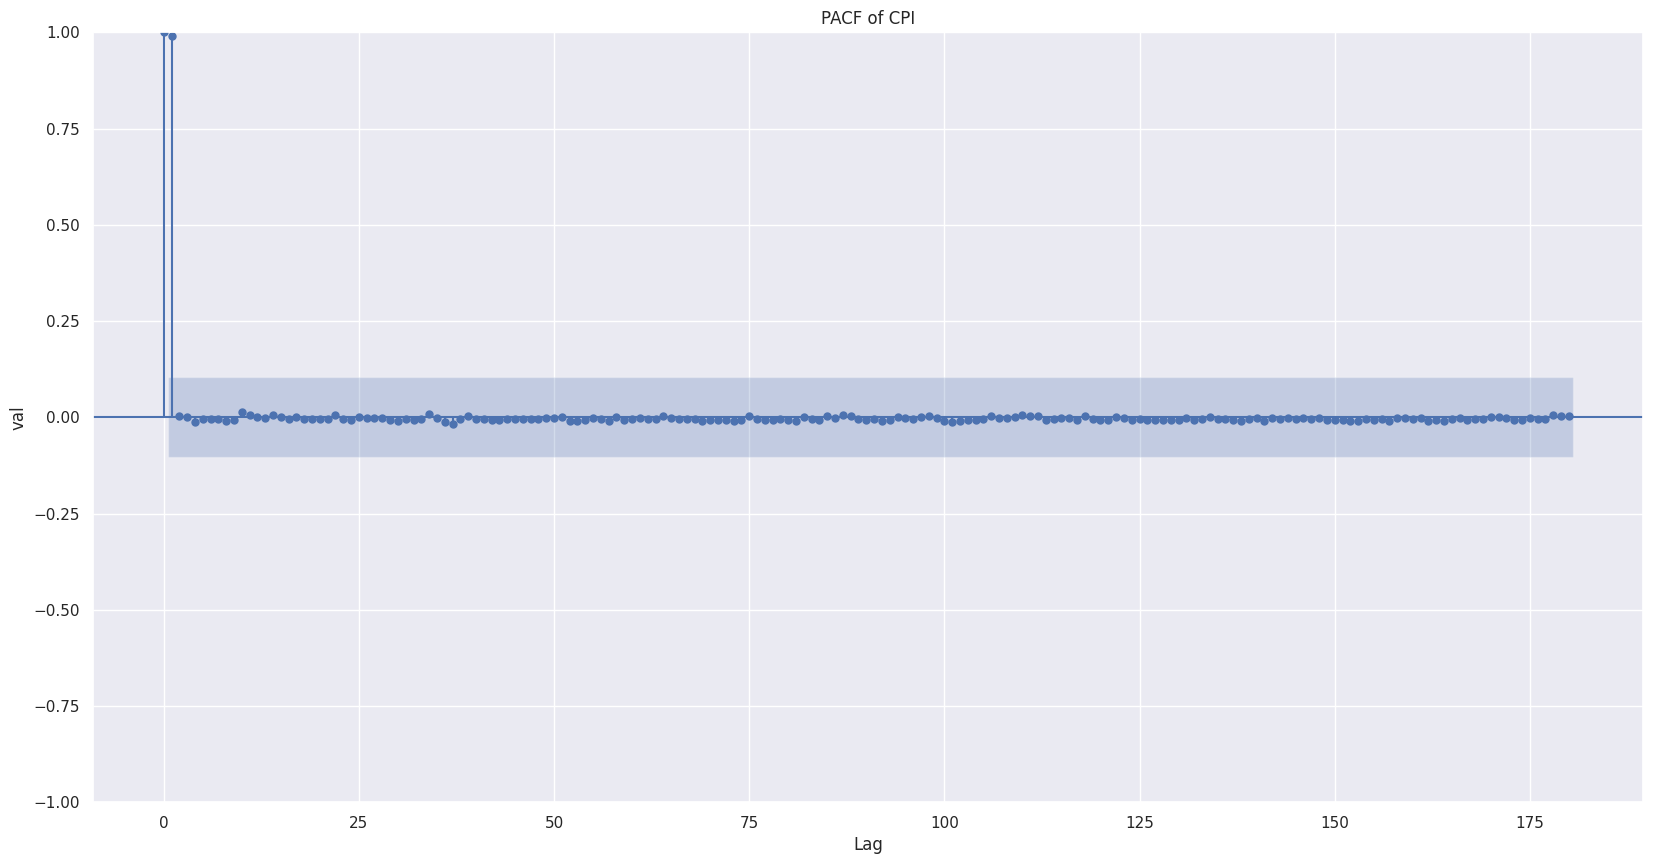

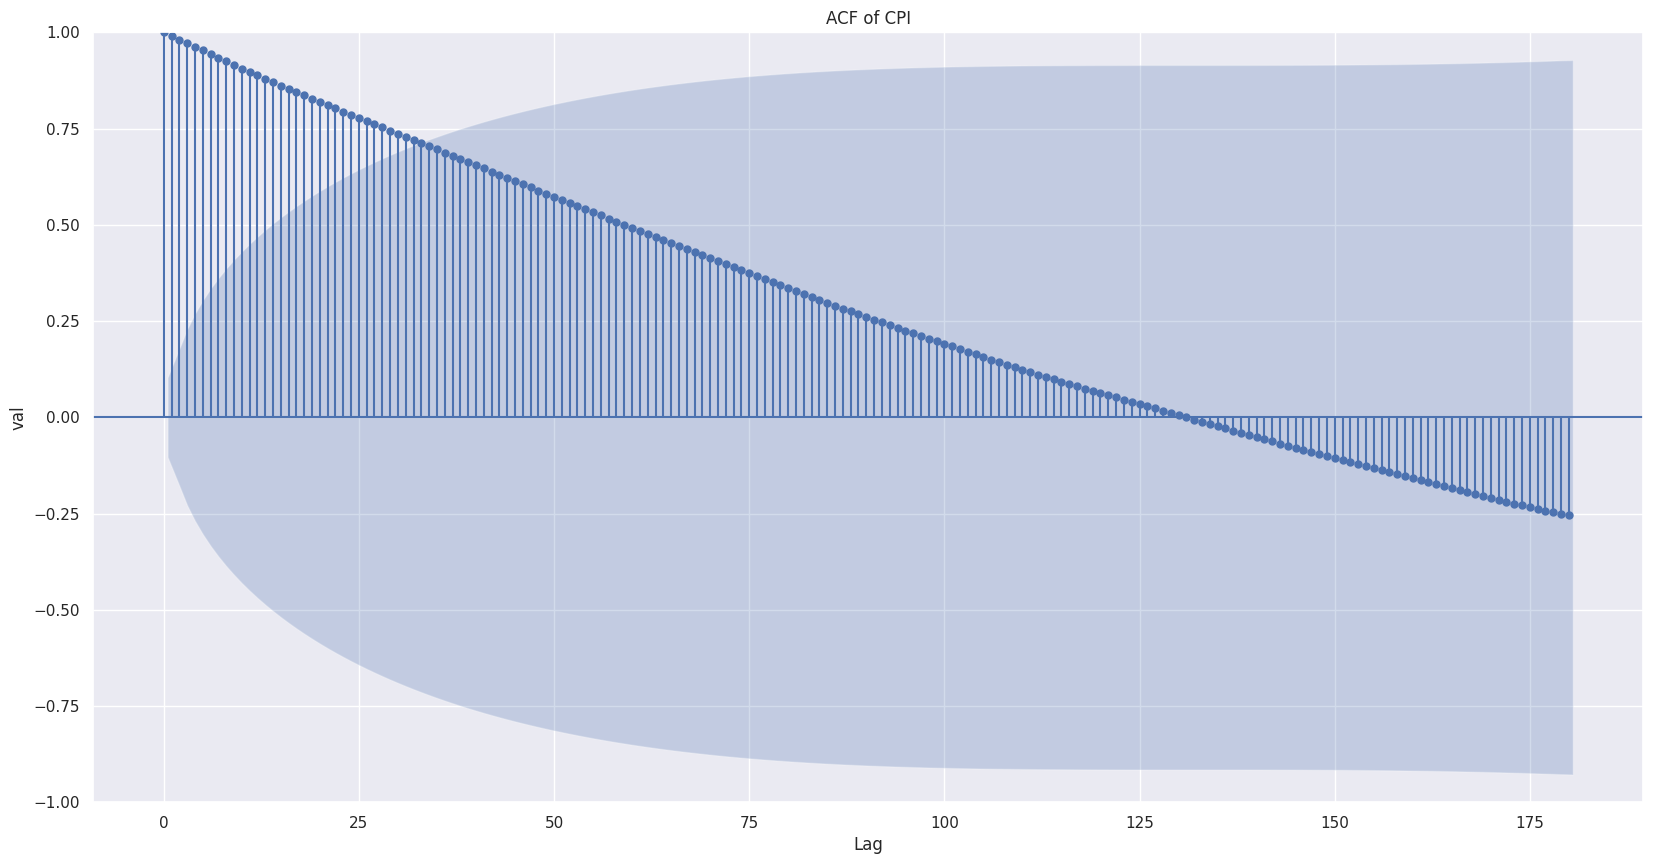

In [9]:
plot_country(normalized_features, years, country)

Correlation between GDP and IR
'Pearson correlation'
{'confidence_interval': [-0.8554117645299792, -0.8122580682913675],
 'mean': -0.8342013051274114,
 'std': 0.011189949891515585}
'Spearman correlation'
{'confidence_interval': [-0.6282238183279235, -0.5586403680333424],
 'mean': -0.5947640080547828,
 'std': 0.01836294460006317}
'Kendall correlation'
{'confidence_interval': [-0.8467416448207375, -0.7862948961059326],
 'mean': -0.8193135461133851,
 'std': 0.01584049884439726}
Correlation between GDP and CPI
'Pearson correlation'
{'confidence_interval': [0.924544062558262, 0.9433230444560184],
 'mean': 0.9343000480283083,
 'std': 0.004863839219386883}
'Spearman correlation'
{'confidence_interval': [0.9211258824872554, 0.9580411632801086],
 'mean': 0.9410838467906837,
 'std': 0.009669147537394437}
'Kendall correlation'
{'confidence_interval': [0.9731359620180483, 0.9922171606313209],
 'mean': 0.9840967816176613,
 'std': 0.00493566611395013}
Correlation between IR and CPI
'Pearson correlat

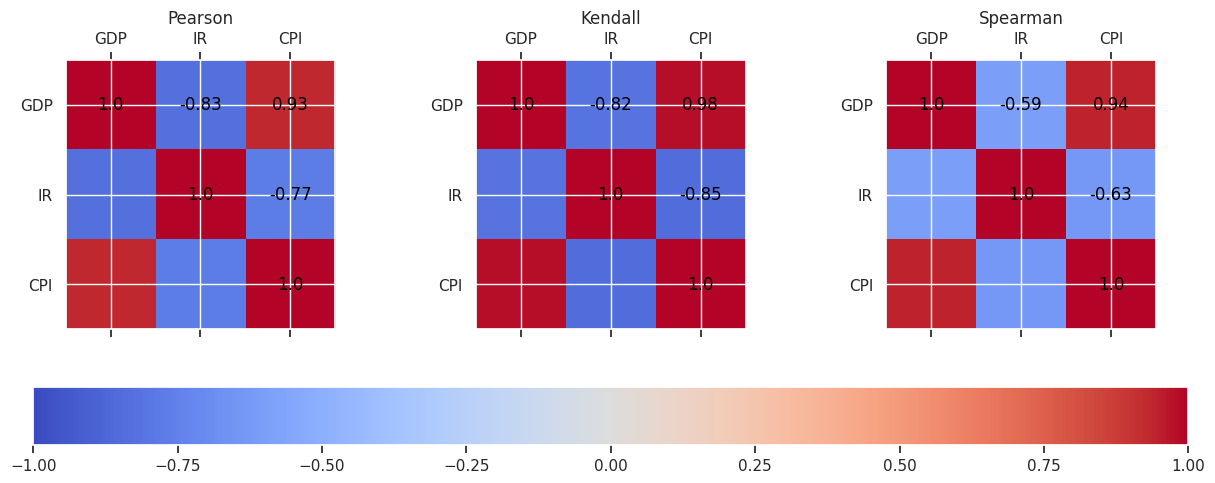

In [10]:
from pprint import pprint
n = len(Indicator)
pearson_matrix = np.ones((n, n))
spearmanr_matrix = np.ones((n, n))
kendall_matrix = np.ones((n, n))

for i in range(n):
    for j in range(i+1, n):
        name1 = Indicator.get_all_names()[i]
        name2 = Indicator.get_all_names()[j]
        indicator1 = Indicator(name1)
        indicator2 = Indicator(name2)
        print(f"Correlation between {indicator1.name} and {indicator2.name}")
        corr = bootstrap_correlation(normalized_features[indicator1], normalized_features[indicator2], 1000, 0.05)
        pprint("Pearson correlation")
        pprint(corr[0])
        pprint("Spearman correlation")
        pprint(corr[1])
        pprint("Kendall correlation")
        pprint(corr[2])

        pearson_matrix[i, j] = corr[0]["mean"]
        pearson_matrix[j, i] = corr[0]["mean"]
        spearmanr_matrix[i, j] = corr[1]["mean"]
        spearmanr_matrix[j, i] = corr[1]["mean"]
        kendall_matrix[i, j] = corr[2]["mean"]
        kendall_matrix[j, i] = corr[2]["mean"]

f, ax = plt.subplots(1, 3, figsize=(15, 5))
cax = ax[0].matshow(pearson_matrix, cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_title("Pearson")
for i in range(3):
    for j in range(i, 3):
        ax[0].text(j, i, round(pearson_matrix[i, j], 2), ha='center', va='center', color='black')

cax = ax[1].matshow(kendall_matrix, cmap="coolwarm", vmin=-1, vmax=1)
ax[1].set_title("Kendall")
for i in range(3,):
    for j in range(i, 3):
        ax[1].text(j, i, round(kendall_matrix[i, j], 2), ha='center', va='center', color='black')

cax = ax[2].matshow(spearmanr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
ax[2].set_title("Spearman")
for i in range(3):
    for j in range(i,3):
        ax[2].text(j, i, round(spearmanr_matrix[i, j], 2), ha='center', va='center', color='black')

for i in range(3):
    ax[i].set_xticks(range(3))
    ax[i].set_yticks(range(3))
    ax[i].set_xticklabels([indicator.name for indicator in Indicator])  
    ax[i].set_yticklabels([indicator.name for indicator in Indicator])

f.colorbar(cax, ax=ax, orientation='horizontal')
plt.show()

In [11]:
# Correlation in residuals
x = np.column_stack(
    [normalized_features[Indicator.IR], normalized_features[Indicator.CPI]]
)
y: Matrix[Literal["N"], Float] = normalized_features[Indicator.GDP]
x: Matrix[Literal["N 3"], Float] = sm.add_constant(x, prepend=True, has_constant="raise")  # type: ignore
model = OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1674.
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          4.00e-182
Time:                        11:51:07   Log-Likelihood:                -1989.0
No. Observations:                 360   AIC:                             3984.
Df Residuals:                     357   BIC:                             3996.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        758.0700     25.899     29.270      0.000     707.136     809.004
x1           -13.4514      1.253    -10.737      0.000     -15.915     -10.987
x2             4.2375      0.153     27.771      0.000       3.937       4.538
==============================================================================
Omnibus:                        4.614   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.339
Skew:                          -0.246   Prob(JB):                        0.114
Kurtosis:                       3.219   Cond. No.                         666.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

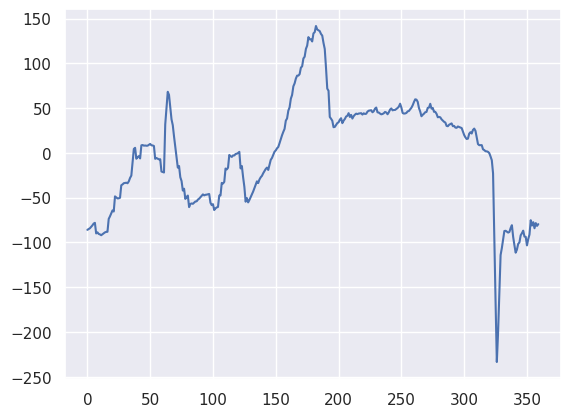

In [12]:
plt.plot(model.resid)

In [13]:
x = np.column_stack(
    [normalized_features[Indicator.IR], normalized_features[Indicator.CPI]]
)
y: Matrix[Literal["N"], Float] = normalized_features[Indicator.GDP]
x: Matrix[Literal["N 3"], Float] = sm.add_constant(x, prepend=True, has_constant="raise")  # type: ignore
model = prais_winsten_estimation(x, y)

Rho =  -0.012231853390892732
Rho =  -0.00012147505946184579


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.310
Model:                            OLS   Adj. R-squared (uncentered):              0.304
Method:                 Least Squares   F-statistic:                              53.40
Date:                Thu, 18 Jul 2024   Prob (F-statistic):                    1.56e-28
Time:                        11:51:08   Log-Likelihood:                         -1206.9
No. Observations:                 360   AIC:                                      2420.
Df Residuals:                     357   BIC:                                      2432.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           475.2547     54.301      8.752      0.000     368.464     582.045
x2             0.1001      0.718      0.139      0.889      -1.312       1.513
x3             3.1794      0.926      3.435      0.001       1.359       5.000
==============================================================================
Omnibus:                      532.164   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357412.870
Skew:                           6.917   Prob(JB):                         0.00
Kurtosis:                     156.741   Cond. No.                         78.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

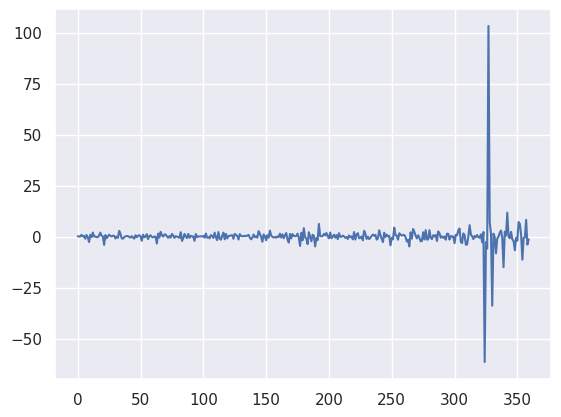

In [15]:
plt.plot(model.resid)